In [148]:
import os
import re
import ast
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from datasets import load_dataset, load_from_disk
from sklearn.metrics import classification_report

tqdm.pandas()
sns.set_style("darkgrid")
sns.set_context("notebook")
aug_regex = re.compile(r"<aug>(.*?)</aug>", re.DOTALL)

In [149]:
# set seeds
np.random.seed(42)

In [150]:
# plotting constants
TITLE_FONT_SIZE = 16
WSPACE = 0.3
FIGURE_HEIGHT = 5
LINE_WIDTH = 2
FIG_SIZE = 4.5

In [151]:

inference_logs = load_from_disk("data/combined_dataset")
list(inference_logs.keys())

['BOSS_Sentiment_ID_BERT_Insert',
 'BOSS_Sentiment_ID_BERT_Substitute',
 'BOSS_Sentiment_ID_BERT_Translate',
 'BOSS_Sentiment_ID_BERT_Paraphrase',
 'BOSS_Sentiment_ID_BERT_ICR',
 'BOSS_Sentiment_ID_T5_Insert',
 'BOSS_Sentiment_ID_T5_Substitute',
 'BOSS_Sentiment_ID_T5_Translate',
 'BOSS_Sentiment_ID_T5_Paraphrase',
 'BOSS_Sentiment_ID_T5_ICR',
 'BOSS_Sentiment_ID_Falcon_Insert',
 'BOSS_Sentiment_ID_Falcon_Substitute',
 'BOSS_Sentiment_ID_Falcon_Translate',
 'BOSS_Sentiment_ID_Falcon_Paraphrase',
 'BOSS_Sentiment_ID_Falcon_ICR',
 'BOSS_Sentiment_SST5_BERT_Insert',
 'BOSS_Sentiment_SST5_BERT_Substitute',
 'BOSS_Sentiment_SST5_BERT_Translate',
 'BOSS_Sentiment_SST5_BERT_Paraphrase',
 'BOSS_Sentiment_SST5_BERT_ICR',
 'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Insert',
 'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Substitute',
 'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Translate',
 'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_Paraphrase',
 'BOSS_Sentiment_Ablate_Data_SST5_BERT1500_ICR',
 'BOSS_Sen

## Analyze Main Results

In [152]:
main_results_bert_splits = [split for split in inference_logs.keys() if "Ablate" not in split]
datasets = ["BOSS_Sentiment", "BOSS_Toxicity", "AgNewsTweets"]
split_data = {}

for task_name in datasets:
    if task_name not in split_data:
        split_data[task_name] = {}

    for split in tqdm(main_results_bert_splits):
        if task_name in split:
            distribution = split.split("_")[-3]
            model = split.split("_")[-2]
            tta_method = split.split("_")[-1]
            baseline_accuracy = classification_report(inference_logs[split]["label"], inference_logs[split]["original_predicted_class"], output_dict=True)["accuracy"]
            tta_accuracy = classification_report(inference_logs[split]["label"], inference_logs[split]["tta_predicted_class"], output_dict=True)["accuracy"]
            accuracy_delta = tta_accuracy - baseline_accuracy

            if model not in split_data[task_name]:
                split_data[task_name][model] = {}

            if tta_method not in split_data[task_name][model]:
                split_data[task_name][model][tta_method] = {}

            split_data[task_name][model][tta_method][distribution] = {
                "distribution": distribution,
                "model": model,
                "tta_method": tta_method,
                "baseline_accuracy": baseline_accuracy,
                "tta_accuracy": tta_accuracy,
                "accuracy_delta": accuracy_delta
            }

    # get the mean accuracy delta for each method excluding ID
    for model_name in split_data[task_name]:
        for tta_method in split_data[task_name][model_name]:
            accuracy_deltas = []
            baseline_accuracies = []
            for distribution in split_data[task_name][model_name][tta_method]:
                if distribution == "ID":
                    continue

                current_tta_result = split_data[task_name][model_name][tta_method][distribution]
                accuracy_deltas.append(current_tta_result["accuracy_delta"])
                baseline_accuracies.append(current_tta_result["baseline_accuracy"])

            split_data[task_name][model_name][tta_method]["mean_accuracy_delta"] = np.mean(accuracy_deltas)
            split_data[task_name][model_name][tta_method]["mean_baseline_accuracy"] = np.mean(baseline_accuracies)

print(json.dumps(split_data, indent=4))

  3%|▎         | 3/112 [00:00<00:14,  7.71it/s]/home/kyle/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kyle/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kyle/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  4%|▎         | 4/1

{
    "BOSS_Sentiment": {
        "BERT": {
            "Insert": {
                "ID": {
                    "distribution": "ID",
                    "model": "BERT",
                    "tta_method": "Insert",
                    "baseline_accuracy": 0.9037888134896155,
                    "tta_accuracy": 0.9048169853999589,
                    "accuracy_delta": 0.001028171910343434
                },
                "SST5": {
                    "distribution": "SST5",
                    "model": "BERT",
                    "tta_method": "Insert",
                    "baseline_accuracy": 0.6847014925373134,
                    "tta_accuracy": 0.683768656716418,
                    "accuracy_delta": -0.0009328358208954279
                },
                "SemEval": {
                    "distribution": "SemEval",
                    "model": "BERT",
                    "tta_method": "Insert",
                    "baseline_accuracy": 0.4497187742435997,
                    "tta_

In [153]:
# create dataframe where there is a column for dataset, model, id_accuracy_delta, and mean_accuracy_delta
records = []

for task_name in tqdm(split_data):
    for model_name in split_data[task_name]:
        for tta_method in split_data[task_name][model_name]:
            current_tta_result = split_data[task_name][model_name][tta_method]
            records.append({
                "dataset": task_name,
                "model": model_name,
                "tta_method": tta_method,
                "id_accuracy_delta": current_tta_result["ID"]["accuracy_delta"] * 100 if "ID" in current_tta_result else None,
                "ood_mean_accuracy_delta": current_tta_result["mean_accuracy_delta"] * 100,
                "ood_mean_baseline_accuracy": current_tta_result["mean_baseline_accuracy"] * 100,
            })


main_results_frame = pd.DataFrame(records)
for model in split_data[task_name]:
    display(model)
    display(main_results_frame[main_results_frame["model"] == model].drop(columns="model").groupby(["dataset", "tta_method"]).mean().T)


100%|██████████| 3/3 [00:00<00:00, 18641.35it/s]


'BERT'

dataset                    AgNewsTweets                                   \
tta_method                          ICR     Insert Paraphrase Substitute   
id_accuracy_delta             -1.302632   0.065789  -1.105263   0.026316   
ood_mean_accuracy_delta        1.184211   0.276316   0.539474   0.289474   
ood_mean_baseline_accuracy    88.565789  88.565789  88.565789  88.565789   

dataset                               BOSS_Sentiment                        \
tta_method                  Translate            ICR     Insert Paraphrase   
id_accuracy_delta           -0.907895       0.472959   0.102817   0.156796   
ood_mean_accuracy_delta      0.250000       4.860502  -0.127494   2.604881   
ood_mean_baseline_accuracy  88.565789      52.050120  52.050120  52.050120   

dataset                                          BOSS_Toxicity             \
tta_method                 Substitute  Translate           ICR     Insert   
id_accuracy_delta           -0.418980  -1.328912      2.904850   0.789149   
ood_mean_accuracy_delta     -0.269537   0.548153      6.841343  -0.807051   
ood_mean_baseline_accuracy  52.050120  52.050120     53.907864  53.907864   

dataset                                                      
tta_method                 Paraphrase Substitute  Translate  
id_accuracy_delta            2.119811   1.437526   1.178586  
ood_mean_accuracy_delta     10.456264  -0.538489   7.739362  
ood_mean_baseline_accuracy  53.907864  53.907864  53.907864

'T5'

dataset                    AgNewsTweets                                   \
tta_method                          ICR     Insert Paraphrase Substitute   
id_accuracy_delta             -2.881579  -2.644737  -2.815789  -2.960526   
ood_mean_accuracy_delta        1.513158   0.578947   1.157895   0.118421   
ood_mean_baseline_accuracy    89.013158  89.013158  89.013158  89.013158   

dataset                               BOSS_Sentiment                        \
tta_method                  Translate            ICR     Insert Paraphrase   
id_accuracy_delta           -2.171053       0.665741  -1.711906  -0.215916   
ood_mean_accuracy_delta      0.026316       1.843384  -1.976507   1.176539   
ood_mean_baseline_accuracy  89.013158      57.988354  57.988354  57.988354   

dataset                                           
tta_method                 Substitute  Translate  
id_accuracy_delta           -4.336315  -2.894304  
ood_mean_accuracy_delta     -2.917087  -1.129824  
ood_mean_baseline_accuracy  57.988354  57.988354

'Falcon'

dataset                    AgNewsTweets                                   \
tta_method                          ICR     Insert Paraphrase Substitute   
id_accuracy_delta             -0.828947  -3.460526  -1.526316  -3.960526   
ood_mean_accuracy_delta        2.157895  -1.039474   1.986842  -1.118421   
ood_mean_baseline_accuracy    26.000000  26.000000  26.000000  26.000000   

dataset                               BOSS_Sentiment                        \
tta_method                  Translate            ICR     Insert Paraphrase   
id_accuracy_delta           -0.184211      -0.149085  -1.082151  -0.149085   
ood_mean_accuracy_delta      0.355263      -2.967050  -0.816995  -1.248467   
ood_mean_baseline_accuracy  26.000000      47.166769  47.166769  47.166769   

dataset                                          BOSS_Toxicity             
tta_method                 Substitute  Translate        Insert Substitute  
id_accuracy_delta           -3.919905  -3.359552     -0.065762   2.982943  
ood_mean_accuracy_delta     -2.898438  -2.186213           NaN        NaN  
ood_mean_baseline_accuracy  47.166769  47.166769           NaN        NaN

# Analyze Across Dataset Sizes

In [154]:
all_splits = [split for split in inference_logs.keys() if "Ablate_Data" in split]
datasets = set([("_".join(split.split("_")[:2]).replace("_Ablate", "")) for split in all_splits if "Ablate_Data" in split])
results = {}
# print(datasets)

for task_name in datasets:
    results[task_name] = {}

    for split_name in tqdm(all_splits, desc=task_name):
        if task_name in split_name:
            data_count = int(split_name.split("_")[-2].replace("BERT", ""))
            tta_method = split_name.split("_")[-1]
            shift_name = split_name.split("_")[-3]
            # print(dataset, data_count, tta_method, shift_name)

            baseline_accuracy = classification_report(inference_logs[split_name]["label"], inference_logs[split_name]["original_predicted_class"], output_dict=True)["accuracy"]
            tta_accuracy = classification_report(inference_logs[split_name]["label"], inference_logs[split_name]["tta_predicted_class"], output_dict=True)["accuracy"]

            if task_name not in results:
                results[task_name] = {}
            if data_count not in results[task_name]:
                results[task_name][data_count] = {}
            if tta_method not in results[task_name][data_count]:
                results[task_name][data_count][tta_method] = {}
            if shift_name not in results[task_name][data_count][tta_method]:
                results[task_name][data_count][tta_method][shift_name] = {}

            results[task_name][data_count][tta_method][shift_name] = {
                "method": tta_method,
                "baseline_accuracy": baseline_accuracy,
                "tta_accuracy": tta_accuracy,
                "baseline_delta": tta_accuracy - baseline_accuracy,
            }

            # inference_frames[task_name] = inference_logs[split].to_pandas()
            # break

print(json.dumps(results, indent=4))

BOSS_Sentiment: 100%|██████████| 175/175 [00:02<00:00, 60.24it/s]

{
    "AgNewsTweets": {
        "4800": {
            "Insert": {
                "Tweets": {
                    "method": "Insert",
                    "baseline_accuracy": 0.8864473684210527,
                    "tta_accuracy": 0.8893421052631579,
                    "baseline_delta": 0.0028947368421052833
                }
            },
            "Substitute": {
                "Tweets": {
                    "method": "Substitute",
                    "baseline_accuracy": 0.8864473684210527,
                    "tta_accuracy": 0.888421052631579,
                    "baseline_delta": 0.0019736842105263497
                }
            },
            "Translate": {
                "Tweets": {
                    "method": "Translate",
                    "baseline_accuracy": 0.8864473684210527,
                    "tta_accuracy": 0.8893421052631579,
                    "baseline_delta": 0.0028947368421052833
                }
            },
            "Paraphrase": {
           

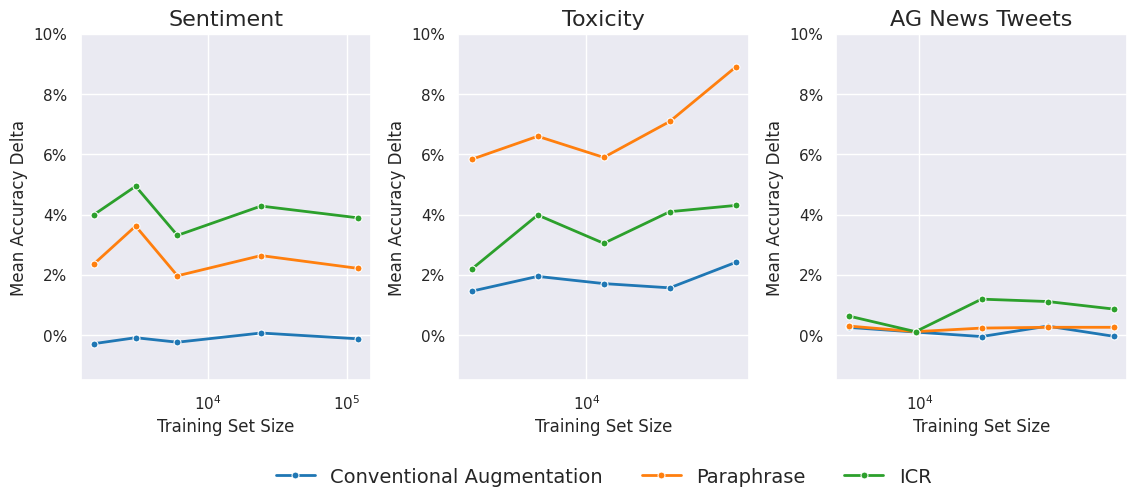

In [155]:
method_avg_delta = {}
for task_name in results:
    for data_count in results[task_name]:
        tta_perf_deltas = {}
        for tta_method in results[task_name][data_count]:
            for ood_shift in results[task_name][data_count][tta_method]:
                if tta_method not in tta_perf_deltas:
                    tta_perf_deltas[tta_method] = []

                shift_method_perf_deta = results[task_name][data_count][tta_method][ood_shift]["baseline_delta"]
                tta_perf_deltas[tta_method].append(shift_method_perf_deta)

        if task_name not in method_avg_delta:
            method_avg_delta[task_name] = {}

        method_avg_delta[task_name][data_count] = { tta_method: np.mean(tta_perf_deltas[tta_method]) for tta_method in tta_perf_deltas }
        baseline = np.mean([method_avg_delta[task_name][data_count]["Insert"], method_avg_delta[task_name][data_count]["Substitute"], method_avg_delta[task_name][data_count]["Translate"]])
        method_avg_delta[task_name][data_count]["Conventional Augmentation"] = baseline

# display(method_avg_delta)

pandas_form = {task_name: {} for task_name in results}
for task_name in pandas_form:
    for data_count in method_avg_delta[task_name]:
        for tta_method in ["Conventional Augmentation", "Paraphrase", "ICR"]:
            if data_count not in pandas_form[task_name]:
                pandas_form[task_name][data_count] = []

            pandas_form[task_name][data_count].append({
                "data_count": data_count,
                "tta_method": tta_method,
                "avg_delta": method_avg_delta[task_name][data_count][tta_method],
            })


fig, axes = plt.subplots(1, 3, figsize=(3 * FIG_SIZE, FIG_SIZE))
for i, task_name in enumerate(["BOSS_Sentiment", "BOSS_Toxicity", "AgNewsTweets"]):
    df = pd.concat([pd.DataFrame(pandas_form[task_name][data_count]) for data_count in pandas_form[task_name]])
    sns.lineplot(
        data=df,
        x="data_count",
        y="avg_delta",
        hue="tta_method",
        ax=axes[i],
        linewidth=LINE_WIDTH,
        marker="o",
        markersize=5)

    # set x label to Training Set Size
    axes[i].set_xlabel("Training Set Size")

    # lgo the x axis
    axes[i].set_xscale("log")
    # axes[i].set_xticks(df["data_count"].sort_values().unique().tolist())

    # create five equally spaced ticks between the min and max of the x axis
    # axes[i].set_xticks(np.linspace(df["data_count"].min(), df["data_count"].max(), 5))

    # set y label to Mean Absolute Accuracy Delta
    axes[i].set_ylabel("Mean Accuracy Delta")

    # make the y axis percents that go to the hundreds place
    axes[i].yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")

    # standardize the y axis
    axes[i].set_ylim(-0.015, 0.1)

    title_text = {
        "BOSS_Sentiment": "Sentiment",
        "BOSS_Toxicity": "Toxicity",
        "AgNewsTweets": "AG News Tweets",
    }
    axes[i].set_title(title_text[task_name], fontsize=TITLE_FONT_SIZE)

    # se legend to the bottom left
    axes[i].legend(loc="lower right")

    # remove leegnd in not middle plot
    if i != 1:
        axes[i].get_legend().remove()
    else:
        # center below plot with no frame
        axes[i].legend(loc="upper center", bbox_to_anchor=(0.5, -0.20), ncol=5, frameon=False, fontsize=14)

# add padding for labels
fig.subplots_adjust(wspace=WSPACE, hspace=WSPACE)

# plt.tight_layout()
if not os.path.exists("figures/"):
    os.makedirs("figures/")
fig.savefig("figures/method_analysis_data_ablation.png", bbox_inches="tight")

# OOD Analysis

In [156]:
ood_sentiment_icr_data = None
ood_toxicity_icr_data = None
ood_tweets_icr_data = None
for split_name in tqdm(inference_logs.keys()):
    current_frame = inference_logs[split_name].to_pandas()
    current_frame["dataset"] = split_name

    if "Sentiment" in split_name and "ICR" in split_name and "ID" not in split_name and "BERT" in split_name and "Ablate" not in split_name:
        if ood_sentiment_icr_data is None:
            ood_sentiment_icr_data = current_frame
        else:
            ood_sentiment_icr_data = pd.concat([ood_sentiment_icr_data, current_frame])

    if "Toxicity" in split_name and "ICR" in split_name and "ID" not in split_name and "BERT" in split_name and "Ablate" not in split_name:
        if ood_toxicity_icr_data is None:
            ood_toxicity_icr_data = current_frame
        else:
            ood_toxicity_icr_data = pd.concat([ood_toxicity_icr_data, current_frame])

    if "Tweets" in split_name and "ICR" in split_name and "ID" not in split_name and "BERT" in split_name and "Ablate" not in split_name:
        if ood_tweets_icr_data is None:
            ood_tweets_icr_data = current_frame
        else:
            ood_tweets_icr_data = pd.concat([ood_tweets_icr_data, current_frame])


display(ood_sentiment_icr_data.value_counts("dataset"))
display(ood_toxicity_icr_data.value_counts("dataset"))
display(ood_tweets_icr_data.value_counts("dataset"))
assert len(ood_sentiment_icr_data.value_counts("dataset")) == 3
assert len(ood_toxicity_icr_data.value_counts("dataset")) == 3
assert len(ood_tweets_icr_data.value_counts("dataset")) == 1

100%|██████████| 287/287 [00:15<00:00, 18.41it/s]


dataset
BOSS_Sentiment_SemEval_BERT_ICR     20624
BOSS_Sentiment_Dynasent_BERT_ICR     4320
BOSS_Sentiment_SST5_BERT_ICR         1072
Name: count, dtype: int64

dataset
BOSS_Toxicity_ImplicitHate_BERT_ICR    21480
BOSS_Toxicity_Toxigen_BERT_ICR           944
BOSS_Toxicity_AdvCivil_BERT_ICR          824
Name: count, dtype: int64

dataset
AgNewsTweets_Tweets_BERT_ICR    7600
Name: count, dtype: int64

## Does TTA Effect Some Classes More Than Others?

In [157]:
# for each dataset, get the percent of examples that are unchanged vs new
sentiment_outcomes = ood_sentiment_icr_data["outcome"]
sentiment_percents = sentiment_outcomes.value_counts(normalize=True)
new_sentiment_percents = 100 * sentiment_percents[sentiment_percents.index == "New Correct"].values[0] + sentiment_percents[sentiment_percents.index == "New Mistake"].values[0]
print(f"Sentiment: {new_sentiment_percents:.2f}% of examples are new predictions")

toxicity_outcomes = ood_toxicity_icr_data["outcome"]
toxicity_percents = toxicity_outcomes.value_counts(normalize=True)
new_toxicity_percents = 100 * toxicity_percents[toxicity_percents.index == "New Correct"].values[0] + toxicity_percents[toxicity_percents.index == "New Mistake"].values[0]
print(f"Toxicity: {new_toxicity_percents:.2f}% of examples are new predictions")

agt_outcomes = ood_tweets_icr_data["outcome"]
agt_percents = agt_outcomes.value_counts(normalize=True)
new_agt_percents = 100 * agt_percents[agt_percents.index == "New Correct"].values[0] + agt_percents[agt_percents.index == "New Mistake"].values[0]
print(f"AGT: {new_agt_percents:.2f}% of examples are new predictions")

Sentiment: 7.81% of examples are new predictions
Toxicity: 8.65% of examples are new predictions
AGT: 1.98% of examples are new predictions


In [158]:
sentiment_icr_outcome_percents = ood_sentiment_icr_data[["outcome", "label"]].sort_values("outcome").value_counts(["outcome", "label"], normalize=True).sort_index()
sentiment_icr_outcome_percents = sentiment_icr_outcome_percents[sentiment_icr_outcome_percents.index.get_level_values("outcome").str.contains("New")]
print("Sentiment ICR")
display(sentiment_icr_outcome_percents)

toxicity_icr_outcome_percents = ood_toxicity_icr_data[["outcome", "label"]].sort_values("outcome").value_counts(["outcome", "label"], normalize=True).sort_index()
toxicity_icr_outcome_percents = toxicity_icr_outcome_percents[toxicity_icr_outcome_percents.index.get_level_values("outcome").str.contains("New")]
print("Toxicity ICR")
display(toxicity_icr_outcome_percents)

tweets_icr_outcome_percents = ood_tweets_icr_data[["outcome", "label"]].sort_values("outcome").value_counts(["outcome", "label"], normalize=True).sort_index()
tweets_icr_outcome_percents = tweets_icr_outcome_percents[tweets_icr_outcome_percents.index.get_level_values("outcome").str.contains("New")]
print("Tweets ICR")
display(tweets_icr_outcome_percents)

Sentiment ICR


outcome      label
New Correct  0        0.012377
             1        0.023524
             2        0.041859
New Mistake  0        0.012915
             1        0.011378
             2        0.010570
Name: proportion, dtype: float64

Toxicity ICR


outcome      label
New Correct  0        0.076652
             1        0.009162
New Mistake  0        0.003011
             1        0.064823
Name: proportion, dtype: float64

Tweets ICR


outcome      label
New Correct  0        0.004342
             1        0.003684
             2        0.009342
             3        0.002368
New Mistake  0        0.002237
             1        0.000263
             2        0.002368
             3        0.003026
Name: proportion, dtype: float64

<Figure size 640x480 with 0 Axes>

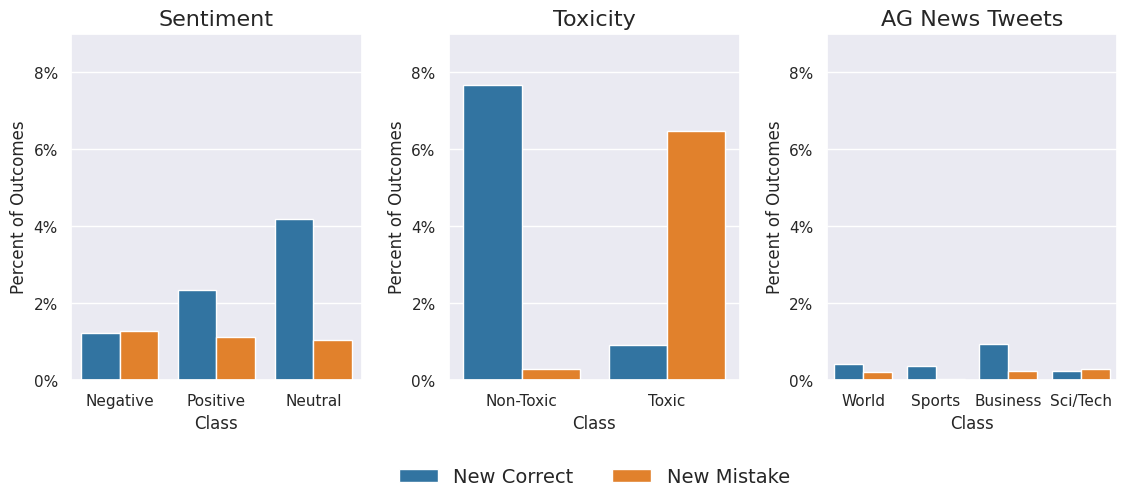

In [159]:
plt.clf()
fig, axes = plt.subplots(1, 3, figsize=(3 * FIG_SIZE, FIG_SIZE))

sentiment_labels = {
    0: "Negative",
    1: "Positive",
    2: "Neutral",
}
sns.barplot(ax=axes[0], 
            x=sentiment_icr_outcome_percents.index.get_level_values("label").map(sentiment_labels), 
            y=sentiment_icr_outcome_percents.values,
            hue=sentiment_icr_outcome_percents.index.get_level_values("outcome"),
)

toxicity_labels = {
    0: "Non-Toxic",
    1: "Toxic",
}
sns.barplot(ax=axes[1],
            x=toxicity_icr_outcome_percents.index.get_level_values("label").map(toxicity_labels),
            y=toxicity_icr_outcome_percents.values,
            hue=toxicity_icr_outcome_percents.index.get_level_values("outcome"),
)

agt_labels = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech",
}
sns.barplot(ax=axes[2],
            x=tweets_icr_outcome_percents.index.get_level_values("label").map(agt_labels),
            y=tweets_icr_outcome_percents.values,
            hue=tweets_icr_outcome_percents.index.get_level_values("outcome"),
)

for i in range(3):
    # make y axis percents
    axes[i].yaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")

    # standardize between 0 and 0.1
    axes[i].set_ylim(0, 0.09)

    # set y label to percent of overall outcomes
    axes[i].set_ylabel("Percent of Outcomes")

    # set x label to Class
    axes[i].set_xlabel("Class")

    # have fewer ticks on the y axis
    axes[i].locator_params(axis="y", nbins=5)

    # set titles
    title_text = {
        0: "Sentiment",
        1: "Toxicity",
        2: "AG News Tweets",
    }
    axes[i].set_title(title_text[i], fontsize=TITLE_FONT_SIZE)

    # have a single legend which is centered below the plot
    if i == 1:
        axes[i].legend(loc="upper center", bbox_to_anchor=(0.5, -0.20), ncol=3, frameon=False, fontsize=14)
    else:
        axes[i].get_legend().remove()

# add more horizental spacing for y labels
fig.subplots_adjust(wspace=WSPACE)
fig.savefig("figures/method_analysis_class_analysis.png", bbox_inches="tight")
fig.show()

# Selective Augmentation

## Calculate Optimal ID Entropy Thresholds

In [160]:
def should_augment_entropy(threshold, row):
    return row["original_prediction_entropy"] >= threshold


def get_entropy_threshold_accuracy(threshold, inference_logs_frame):
    threshold_judgments = inference_logs_frame.apply(lambda row: row["tta_predicted_class"] if should_augment_entropy(threshold, row) else row["original_predicted_class"], axis=1)
    report = classification_report(inference_logs_frame["label"], threshold_judgments, digits=4, output_dict=True, zero_division=0)
    llm_call_count = inference_logs_frame.apply(lambda row: should_augment_entropy(threshold, row), axis=1).sum()
    llm_call_rate = llm_call_count / len(inference_logs_frame)
    return report["accuracy"], llm_call_rate


def should_augment_softmax(threshold, row):
    try:
        return row["tta_all_class_probs"][-1].max() < threshold
    except:
        return False


def get_max_softmax_threshold_accuracy(threshold, inference_logs_frame):
    threshold_judgments = inference_logs_frame.apply(lambda row: row["tta_predicted_class"] if should_augment_softmax(threshold, row) else row["original_predicted_class"], axis=1)
    report = classification_report(inference_logs_frame["label"], threshold_judgments, digits=4, output_dict=True, zero_division=0)
    llm_call_count = (inference_logs_frame["original_prediction_entropy"] >= threshold).sum()
    llm_call_rate = llm_call_count / len(inference_logs_frame)
    return report["accuracy"], llm_call_rate

thresholds = np.arange(0, 1.2, 0.0001)
print(f"Number of thresholds: {len(thresholds)}")
thresholds

Number of thresholds: 12000


array([0.0000e+00, 1.0000e-04, 2.0000e-04, ..., 1.1997e+00, 1.1998e+00,
       1.1999e+00])

## OOD Entropy Threshold Analysis 

In [161]:
# 1. Calculate all the tresholds for each OOD split for BERT ICR. 
# 2. Get the manual threshold for each OOD split for BERT ICR at different augmentation rates.

thresholds_dict = {}
thresholds_path = f"data/thresholds_dict_{len(thresholds)}.json"
if not os.path.exists(thresholds_path):
    for ood_icr_data in [ood_sentiment_icr_data, ood_toxicity_icr_data, ood_tweets_icr_data]:
        for split in ood_icr_data["dataset"].unique():
            print(split)
            thresholds_dict[split] = {}
            split_frame = ood_icr_data[ood_icr_data["dataset"] == split]
            original_accuracy = classification_report(split_frame["label"], split_frame["original_predicted_class"], output_dict=True)["accuracy"]
            
            for threshold in tqdm(thresholds):
                accuracy, llm_call_rate = get_entropy_threshold_accuracy(threshold, split_frame)
                thresholds_dict[split][threshold] = {
                    "accuracy": accuracy,
                    "accuracy_delta": accuracy - original_accuracy,
                    "llm_call_rate": llm_call_rate,
                }
    json.dump(thresholds_dict, open(thresholds_path, "w"), indent=4)
else:
    with open("data/thresholds_dict.json", "r") as f:
        thresholds_dict = json.load(f)

print(json.dumps(thresholds_dict, indent=4))

{
    "BOSS_Sentiment_SST5_BERT_ICR": {
        "0.0": {
            "accuracy": 0.7397388059701493,
            "accuracy_delta": 0.05503731343283591,
            "llm_call_rate": 1.0
        },
        "0.001": {
            "accuracy": 0.7397388059701493,
            "accuracy_delta": 0.05503731343283591,
            "llm_call_rate": 1.0
        },
        "0.002": {
            "accuracy": 0.7397388059701493,
            "accuracy_delta": 0.05503731343283591,
            "llm_call_rate": 1.0
        },
        "0.003": {
            "accuracy": 0.7397388059701493,
            "accuracy_delta": 0.05503731343283591,
            "llm_call_rate": 1.0
        },
        "0.004": {
            "accuracy": 0.7397388059701493,
            "accuracy_delta": 0.05503731343283591,
            "llm_call_rate": 1.0
        },
        "0.005": {
            "accuracy": 0.7397388059701493,
            "accuracy_delta": 0.05503731343283591,
            "llm_call_rate": 1.0
        },
        "0.006

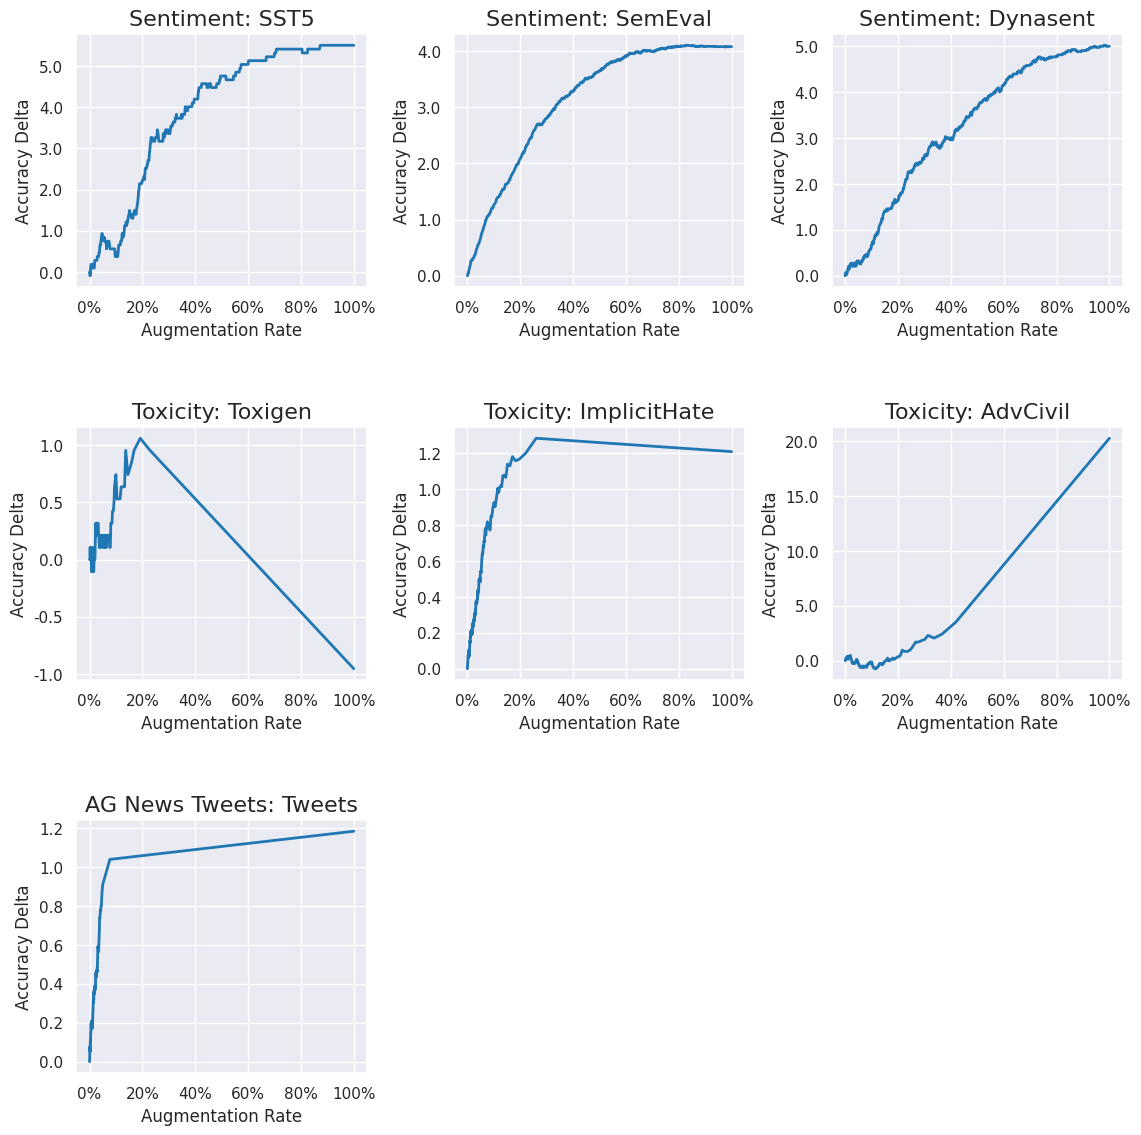

In [162]:
# create a subplot for each dataset in the thresholds dict with three on each row
fig, axes = plt.subplots(3, 3, figsize=(3 * FIG_SIZE, 3 * FIG_SIZE))

# use the first row for sentiment, second for toxicity, and third for agt
task_keys = [
    [key for key in thresholds_dict.keys() if "Sentiment" in key],
    [key for key in thresholds_dict.keys() if "Toxicity" in key],
    [key for key in thresholds_dict.keys() if "Tweets" in key],
]
for row_index, task_splits in enumerate(task_keys):
    for col_index in range(len(task_splits)):
        split_name = task_splits[col_index]
        thresholds_split_frame = pd.DataFrame(thresholds_dict[split_name]).T.reset_index().sort_values("llm_call_rate")
        sns.lineplot(
            ax=axes[row_index, col_index],
            data=thresholds_split_frame,
            x="llm_call_rate",
            y="accuracy_delta",
            linewidth=LINE_WIDTH)

        row_titles = {
            0: "Sentiment",
            1: "Toxicity",
            2: "AG News Tweets",
        }
        shift_name = split_name.split("_")[-3]
        axes[row_index, col_index].set_title(f"{row_titles[row_index]}: {shift_name}", fontsize=TITLE_FONT_SIZE)

for col_index in range(3):
    for row_index in range(3):
        axes[row_index, col_index].set_ylabel("Accuracy Delta")
        axes[row_index, col_index].set_xlabel("Augmentation Rate")

        # set x and y axis to percents
        axes[row_index, col_index].xaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")

        # multiple delta by 100 to get percent
        axes[row_index, col_index].yaxis.set_major_formatter(lambda x, pos: f"{round(x * 100, 2)}")

        # set y axis between -0.1 and 0.1
        # axes[row_index, col_index].set_ylim(-0.01, 0.15)

        # have five ticks on the y axis
        axes[row_index, col_index].locator_params(axis="y", nbins=8)

        # delete last two plots on the final row
        if row_index == 2 and col_index > 0:
            axes[row_index, col_index].remove()

# add padding for labels
fig.subplots_adjust(wspace=WSPACE, hspace=WSPACE + 0.25)

# save figure
fig.savefig("figures/method_analysis_all_entropy_thresholds.png", bbox_inches="tight")

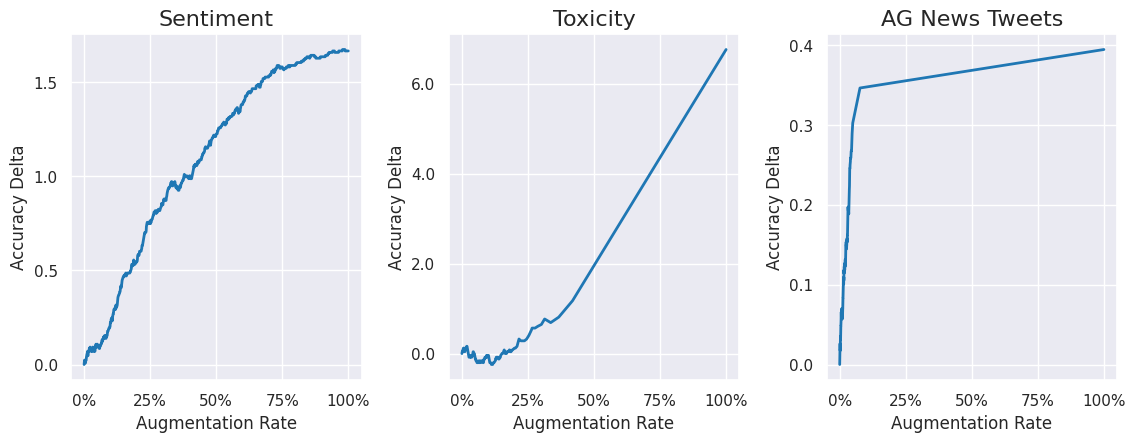

In [163]:
aggregated_sentiment_thresholds = {}
for split in thresholds_dict:
    task = "Sentiment" if "Sentiment" in split else "Toxicity" if "Toxicity" in split else "AG News Tweets"
    if task not in aggregated_sentiment_thresholds:
        aggregated_sentiment_thresholds[task] = {}

    for threshold in thresholds_dict[split]:
        if threshold not in aggregated_sentiment_thresholds:
            aggregated_sentiment_thresholds[task][threshold] = {
                "accuracy_delta": 0,
                "llm_call_rate": 0,
            }

        aggregated_sentiment_thresholds[task][threshold]["accuracy_delta"] += thresholds_dict[split][threshold]["accuracy_delta"]
        aggregated_sentiment_thresholds[task][threshold]["llm_call_rate"] += thresholds_dict[split][threshold]["llm_call_rate"]

# divide each accuracy delta by the number of splits to get the average
for task in aggregated_sentiment_thresholds:
    for threshold in aggregated_sentiment_thresholds[task]:
        aggregated_sentiment_thresholds[task][threshold]["accuracy_delta"] /= 3
        # aggregated_sentiment_thresholds[task][threshold]["llm_call_rate"] /= 3

fig, axes = plt.subplots(1, 3, figsize=(3 * FIG_SIZE, FIG_SIZE))
for col_index, task in enumerate(aggregated_sentiment_thresholds):
    sns.lineplot(
        ax=axes[col_index],
        data=pd.DataFrame(aggregated_sentiment_thresholds[task]).T.reset_index().sort_values("llm_call_rate"),
        x="llm_call_rate",
        y="accuracy_delta",
        linewidth=LINE_WIDTH)
    

    axes[col_index].set_title(task, fontsize=TITLE_FONT_SIZE)

    # add padding for labels
    axes[col_index].set_ylabel("Accuracy Delta")
    axes[col_index].set_xlabel("Augmentation Rate")

    # set x and y axis to percents
    axes[col_index].xaxis.set_major_formatter(lambda x, pos: f"{x:.0%}")
    axes[col_index].yaxis.set_major_formatter(lambda x, pos: f"{round(x * 100, 2)}")

    # set y value between 0 and 0.1
    # axes[col_index].set_ylim(-0.01, 0.08)

    # have few ticks on the x axis
    axes[col_index].locator_params(axis="x", nbins=5)
    axes[col_index].locator_params(axis="y", nbins=5)

fig.subplots_adjust(wspace=WSPACE, hspace=0.3)
fig.savefig("figures/method_analysis_aggregated_entropy_thresholds.png", bbox_inches="tight")

### Selective Augmentation

In [164]:
def set_tta_preds(row):
    if row["generations"] is not None and len(row["generations"]) > 0:
        return row["generations"][:5]
    
    if row["tta_all_class_probs"] is None:
        return None

    all_probs = row["tta_all_class_probs"][:5]
    arg_maxes = [prob_dist.argmax() for prob_dist in all_probs]
    return arg_maxes

def is_entropy_split(split_name):
    if "BERT" not in split_name:
        return False
    if "Ablate" in split_name:
        return False
    if "ID" in split_name:
        return False

    return "Paraphrase" in split_name or "ICR" in split_name

In [165]:
optimal_entropy_thresholds = {}
optimal_softmax_thresholds = {}
thresholds = np.arange(0, 1.2, 0.0005)
SAMPLE_SIZE = 250
print(f"Number of thresholds: {len(thresholds)}")

for split in [dataset for dataset in inference_logs if is_entropy_split(dataset)]:
    print(split)
    best_entropy_threshold = None
    best_softmax_threshold = None
    split_frame = inference_logs[split].to_pandas()
    sample_frame = None
    unique_predicted_classes = [class_label for class_label in split_frame["tta_predicted_class"].unique() if class_label != -1] 
    for class_prediction in unique_predicted_classes:
        sample_size = SAMPLE_SIZE // len(unique_predicted_classes)
        class_sample_frame = split_frame[split_frame["tta_predicted_class"] == class_prediction].sample(sample_size, random_state=42)
        if sample_frame is None:
            sample_frame = class_sample_frame
        else:
            sample_frame = pd.concat([sample_frame, class_sample_frame])
    
    threshold_performances = []
    for threshold in tqdm(thresholds):
        accuracy, llm_call_rate = get_entropy_threshold_accuracy(threshold, sample_frame)
        beta = 1/500
        rate_term = 1 - llm_call_rate
        threshold_score = (1 + beta ** 2) * ((accuracy * rate_term) / ((beta ** 2) * accuracy + rate_term))
        threshold_perf = {
            "threshold": threshold,
            "accuracy": accuracy,
            "score": threshold_score,
            "llm_call_rate": f"{llm_call_rate:.2f}%",
        }
        threshold_performances.append(threshold_perf)

        # if best_entropy_threshold is None or accuracy > best_entropy_threshold["accuracy"]:
        if best_entropy_threshold is None or threshold_score > best_entropy_threshold["score"]:
            best_entropy_threshold = threshold_perf

    pd.DataFrame(threshold_performances).to_csv(f"data/threshold_performances_{split}.csv", index=False)
    optimal_entropy_thresholds[split] = best_entropy_threshold
    print(f"Best Entropy Threshold: {best_entropy_threshold}")

# print(json.dumps(optimal_entropy_thresholds, indent=4))
# print(json.dumps(optimal_softmax_thresholds, indent=4))


Number of thresholds: 2400
BOSS_Sentiment_SST5_BERT_Paraphrase


100%|██████████| 2400/2400 [00:20<00:00, 118.02it/s]


Best Entropy Threshold: {'threshold': 0.7055, 'accuracy': 0.7228915662650602, 'score': 0.7228917184521816, 'llm_call_rate': '0.24%'}
BOSS_Sentiment_SST5_BERT_ICR


100%|██████████| 2400/2400 [00:20<00:00, 118.55it/s]


Best Entropy Threshold: {'threshold': 0.3305, 'accuracy': 0.7791164658634538, 'score': 0.77911398425106, 'llm_call_rate': '0.57%'}
BOSS_Sentiment_SemEval_BERT_Paraphrase


100%|██████████| 2400/2400 [00:20<00:00, 116.20it/s]


Best Entropy Threshold: {'threshold': 0.6235, 'accuracy': 0.5020080321285141, 'score': 0.5020067803763544, 'llm_call_rate': '0.69%'}
BOSS_Sentiment_SemEval_BERT_ICR


100%|██████████| 2400/2400 [00:20<00:00, 118.53it/s]


Best Entropy Threshold: {'threshold': 0.33, 'accuracy': 0.4819277108433735, 'score': 0.48192413084986424, 'llm_call_rate': '0.83%'}
BOSS_Sentiment_Dynasent_BERT_Paraphrase


100%|██████████| 2400/2400 [00:19<00:00, 120.03it/s]


Best Entropy Threshold: {'threshold': 0.9615, 'accuracy': 0.5180722891566265, 'score': 0.5180730823753978, 'llm_call_rate': '0.16%'}
BOSS_Sentiment_Dynasent_BERT_ICR


100%|██████████| 2400/2400 [00:20<00:00, 117.81it/s]


Best Entropy Threshold: {'threshold': 0.14200000000000002, 'accuracy': 0.4457831325301205, 'score': 0.4457684222310281, 'llm_call_rate': '0.95%'}
BOSS_Toxicity_Toxigen_BERT_Paraphrase


100%|██████████| 2400/2400 [00:20<00:00, 117.46it/s]


Best Entropy Threshold: {'threshold': 0.013000000000000001, 'accuracy': 0.696, 'score': 0.6960006310380479, 'llm_call_rate': '0.10%'}
BOSS_Toxicity_Toxigen_BERT_ICR


100%|██████████| 2400/2400 [00:20<00:00, 118.41it/s]


Best Entropy Threshold: {'threshold': 0.0055, 'accuracy': 0.704, 'score': 0.7040004891627023, 'llm_call_rate': '0.15%'}
BOSS_Toxicity_ImplicitHate_BERT_Paraphrase


100%|██████████| 2400/2400 [00:21<00:00, 113.74it/s]


Best Entropy Threshold: {'threshold': 0.0035, 'accuracy': 0.672, 'score': 0.6720003839986834, 'llm_call_rate': '0.22%'}
BOSS_Toxicity_ImplicitHate_BERT_ICR


100%|██████████| 2400/2400 [00:20<00:00, 117.25it/s]


Best Entropy Threshold: {'threshold': 0.001, 'accuracy': 0.68, 'score': 0.6800003241439357, 'llm_call_rate': '0.23%'}
BOSS_Toxicity_AdvCivil_BERT_Paraphrase


100%|██████████| 2400/2400 [00:20<00:00, 114.89it/s]


Best Entropy Threshold: {'threshold': 0.0005, 'accuracy': 0.42, 'score': 0.4200003536830935, 'llm_call_rate': '0.47%'}
BOSS_Toxicity_AdvCivil_BERT_ICR


100%|██████████| 2400/2400 [00:20<00:00, 118.75it/s]


Best Entropy Threshold: {'threshold': 0.0005, 'accuracy': 0.38, 'score': 0.3800003918738366, 'llm_call_rate': '0.49%'}
AgNewsTweets_Tweets_BERT_Paraphrase


100%|██████████| 2400/2400 [00:20<00:00, 119.51it/s]


Best Entropy Threshold: {'threshold': 0.6890000000000001, 'accuracy': 0.8830645161290323, 'score': 0.8830649291738791, 'llm_call_rate': '0.00%'}
AgNewsTweets_Tweets_BERT_ICR


100%|██████████| 2400/2400 [00:20<00:00, 118.73it/s]

Best Entropy Threshold: {'threshold': 0.001, 'accuracy': 0.8911290322580645, 'score': 0.891129095626991, 'llm_call_rate': '0.09%'}


In [166]:
perf_records = []

# display(id_logs)
# display(split_names)
for split_name in tqdm(optimal_entropy_thresholds):
    split_logs = inference_logs[split_name].to_pandas()

    perf_records.append({
        "split": split_name,
        "tta": "None",
        "accuracy": classification_report(split_logs["label"], split_logs["original_predicted_class"], digits=4, zero_division=0, output_dict=True)["accuracy"],
    })

    optimal_entropy_threshold = optimal_entropy_thresholds[split_name]["threshold"]
    accuracy = get_entropy_threshold_accuracy(optimal_entropy_threshold, split_logs)[0]
    perf_records.append({
        "split": split_name,
        "tta": "entropy-based",
        "accuracy": accuracy,
        "augmentation_rate": split_logs.apply(lambda row: should_augment_entropy(optimal_entropy_threshold, row), axis=1).sum() / len(split_logs),
    })


100%|██████████| 14/14 [00:02<00:00,  5.28it/s]


In [167]:
results_frame = pd.DataFrame(perf_records)
results_frame["Dataset"] = results_frame["split"].apply(lambda s: s.split("_")[-4])
results_frame["Distribution"] = results_frame["split"].apply(lambda s: s.split("_")[-3])
results_frame["Model"] = results_frame["split"].apply(lambda s: s.split("_")[-2])
results_frame["TTA Method"] = results_frame["split"].apply(lambda s: s.split("_")[-1])
results_frame["Baseline Delta"] = results_frame.apply(lambda row: row["accuracy"] - results_frame[(results_frame["split"] == row["split"]) & (results_frame["tta"] == "None")]["accuracy"].values[0], axis=1)
results_frame.drop(columns=["split"], inplace=True)
results_frame.rename(columns={"tta": "Selective Method", "accuracy": "Accuracy", "augmentation_rate": "Augmentation Rate"}, inplace=True)

aggregated_results = results_frame.groupby(["Dataset", "Distribution", "Model", "TTA Method", "Selective Method"]).mean().round(4) * 100
aggregated_results = aggregated_results.sort_values(by=["Dataset", "Distribution", "Model", "TTA Method", "Accuracy"], ascending=False)

print("Overall Results")
# display(aggregated_results)

# Average each TTA Method and Selective Method over distributions
results_frame["ID"] = results_frame["Distribution"].apply(lambda d: "ID" in d)
results_frame.drop(columns=["Distribution", "Accuracy"], inplace=True)
results_frame = results_frame[["Dataset", "ID", "Model", "TTA Method", "Selective Method", "Baseline Delta", "Augmentation Rate"]]
aggregated_results = results_frame.groupby(["Dataset", "ID", "Model", "TTA Method", "Selective Method"]).mean().round(4) * 100
aggregated_results = aggregated_results.sort_values(by=["Dataset", "ID", "Model", "TTA Method", "Baseline Delta"], ascending=False)
print("Average Results")
for dataset in ["Sentiment", "Toxicity", "AgNewsTweets"]:
    for tta_method in ["Paraphrase", "ICR"]:
    # for tta_method in ["ICR"]:
        print(f"Dataset: {dataset}, TTA Method: {tta_method}")
        # display(aggregated_results.loc[dataset, :, :, tta_method, :])
        # only show entropy-based
        display(aggregated_results.loc[dataset, :, :, tta_method, "entropy-based"])

Overall Results
Average Results
Dataset: Sentiment, TTA Method: Paraphrase


,,Baseline Delta,Augmentation Rate
ID,Model,,
False,BERT,1.76,32.94


Dataset: Sentiment, TTA Method: ICR


,,Baseline Delta,Augmentation Rate
ID,Model,,
False,BERT,4.68,77.19


Dataset: Toxicity, TTA Method: Paraphrase


,,Baseline Delta,Augmentation Rate
ID,Model,,
False,BERT,4.09,25.29


Dataset: Toxicity, TTA Method: ICR


,,Baseline Delta,Augmentation Rate
ID,Model,,
False,BERT,2.37,29.26


Dataset: AgNewsTweets, TTA Method: Paraphrase


,,Baseline Delta,Augmentation Rate
ID,Model,,
False,BERT,0.04,0.11


Dataset: AgNewsTweets, TTA Method: ICR


,,Baseline Delta,Augmentation Rate
ID,Model,,
False,BERT,1.04,7.67
